<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> Integración Numérica </h2>
    <h2> [[S]cientific [C]omputing [T]eam](#acknowledgements)</h2>
    <h2> Version: 1.1</h2>
</center>

# Tabla de Contenidos
* [Introducción](#intro)
* [Configuraciones](#config)
* [Sumas de Riemann](#sr)
* [Métodos de Newton-Cotes](#nc)
    * [Regla del Trapecio](#rt)
    * [Regla de Simpson](#rs)
    * [Midpoint](#mp)
* [Cuadratura Gaussiana](#cg)
* [Análisis de Convergencia](#ac)
* [Análisis de Tiempo](#at)
* [Acknowledgements](#acknowledgements)

<div id='intro' />
# Introducción
En este notebook estudiaremos métodos numéricos para integrar numéricamente funciones de distinto tipo. Las motivaciones para la utilización de estos métodos son varias, algunas de ellas:
* El cálculo teórico de la antiderivada de una función es un proceso tedioso, incluso para librerías de álgebra simbólica como `SymPy`.
* Peor que lo anterior, existen funciones que no tienen [integral elemental](https://en.wikipedia.org/wiki/Nonelementary_integral), esto es, aquellas cuya antiderivada no puede ser expresada como una _expresión_ de funciones elementales. Un ejemplo clásico es:
$$ \int e^{-x^2}dx $$
* Como veremos, existen métodos numéricos sumamente precisos, para los cuales el error que se comete debido a las aproximaciones, converge rápidamente a $0$ a medida que se aumenta la cantidad de puntos en la malla utilizada.

Partiendo de la noción geométrica de la integral definida, como aquella cantidad que expresa el __área bajo la curva__ de una función, nacen los distintos métodos que estudiaremos a continuación.

<div id='config' />
# Configuraciones

### Librerías utilizadas en el notebook

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import math
import time

La siguiente función nos permitirá graficar y visualizar apropiadamente los resultados.

In [2]:
###########################################################################
# General plotting framework
###########################################################################
def plot(f, xbin, ybin, int_val, N, text, figname=""):
    plt.figure(figsize=(12,6))
    n = 201
    # Get a representation of f as a continuous function
    x = np.linspace(xbin.min(), xbin.max(), n)
    y = f(x)
    # Plot the function
    plt.plot(x, y, 'r', lw=2.0)
    # Plot the interpolation
    plt.fill_between(xbin, 0, ybin, alpha=0.25, lw=2.0)
    # Setting the lims
    ymin, ymax = y.min(), y.max()
    if abs(ymax-ymin)<1E-6:
        ymin, ymax = 0.0, 1.0
    dy = .1*(ymax-ymin)
    plt.ylim([ymin-dy,ymax+dy])
    xmin, xmax = x.min(), x.max()
    if abs(b-a)<1E-6:
        xmin, xmax = 0.0, 1.0
    dx = .1*(b-a)
    plt.xlim([xmin-dx,xmax+dx])
    # Do the text
    if N>1:
        text_N = r"$%s \approx %.5f$ (usando %d evaluaciones de $f$)" %(text, int_val, N)
        plt.text(min(x), max(y), text_N, fontsize=18)
        #plt.text(min(x), 0.9*max(y), "Valor exacto $2.35040$", fontsize=18)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    return

### Parámetros

Para los experimentos numéricos, consideraremos la función $f(x)$ con dominio $x \in [a,b]$. El número de puntos a utilizar en las mallas equiespaciadas vendrá definido por $N$. Todas las anteriores se definen en la celda siguiente.

In [3]:
#limits of integration
a = -1; b = 1
#function to integrate
myfun = lambda x : np.exp(-x) #x**2 #1 # x #np.exp(-x)
#number the points in the 1D grid
N = 2
#text to show in the graphs
text= r"\int_{%+.2f}^{%+.2f} e^x dx" %(a,b)

<div id='sr' />
# Sumas de Riemann

Como primera aproximación hacia la integración numérica, revisaremos la suma que compone la base sobre la cual se define una integral definida: **La integral de Riemann**. Esta consiste en particionar el dominio de integración $D = [a,b] \rightarrow a = x_0 < x_1 < \cdots < x_{n-1} < x_n = b $, de tal modo que para cada partición $[x_k,x_{k+1}]$ aproximemos el área bajo $f$ por rectángulos, tomando como altura de los rectángulos a $f(c)$ con $c \in [x_k,x_{k+1}]$. Cuando se elige tal $c$ como uno de los extremos de la partición, se da origen a las siguiente dos aproximaciones:  

### Suma izquierda de Riemann
Eligiendo $c = x_{k}$ (extremo izquierdo) para cada partición, sobre una malla regular de ancho $x_{k+1}-x_{k}=\Delta x$:
\begin{align*}
A = \int_a^b f(x) dx & \approx \sum_{k=0}^{n-1} f(x_k) \Delta x
\end{align*}

### Suma derecha de Riemann
Eligiendo $c = x_{k+1}$ (extremo derecho) para cada partición, sobre una malla regular de ancho $x_{k+1}-x_{k}=\Delta x$:
\begin{align*}
A = \int_a^b f(x) dx \approx \sum_{k=1}^{n} f(x_k)\Delta x
\end{align*}

El código que se provee a continuación, implementa la integración numérica por sumas de Riemann.

/Users/claudio/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:18: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/claudio/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


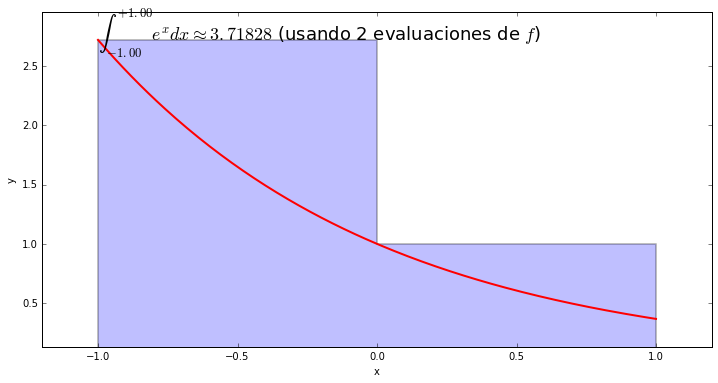

Approximated sum: 3.718281828459045


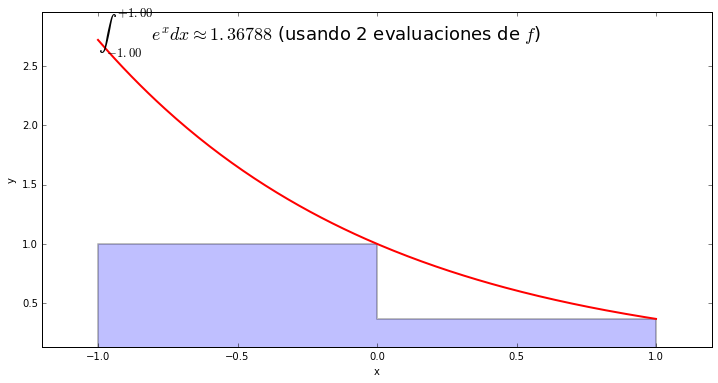

Approximated sum: 1.3678794411714423


In [4]:
###########################################################################
# Riemann Rule
###########################################################################
def riemann(myfun, N, a, b, direction="left", verbose=False, text=text, figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    dx = x[1]-x[0]
    if direction=="left":
        points = x[:-1]
    elif direction=="right":
        points = x[1:]
    else:
        print("Riemann Sum: choose left or right")
        return
    point_values = f(points)
    int_val = sum(point_values*dx)
    if verbose:
        xbin = np.vstack([x[:-1], x[1:]]).flatten(1)
        ybin = np.vstack([point_values, point_values]).flatten(1)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

print('Approximated sum: {0}'.format(riemann(myfun, N, a, b, direction="left", 
                                    verbose=True, figname="riemann_left_%d.png"%N)))
print('Approximated sum: {0}'.format(riemann(myfun, N, a, b, direction="right", 
                                    verbose=True, figname="riemann_right_%d.png"%N)))

<div id='nc' />
# Métodos de Newton-Cotes

Los siguientes dos métodos que se presentan a continuación, conforman parte de una familia de métodos llamados de Newton-Cotes. Estos generan una malla equiespaciada para particionar el dominio de integración $[a,b]$.

Todos estos métodos se basan en aproximar la función $f$ por un __polinomio__ de grado $n-1: \ p_{n-1}$, que interpole $n$ puntos de tal malla, y de este modo computar el área bajo la curva de este polinomio (En vez de $f$), lo cual es fácil dado que las integrales de polinomios son también polinomios (de un grado superior).

Las derivaciones de las fórmulas a utilizar pueden ser consultadas en el texto guía: _Numerical Analysis, Timothy Sauer_.

<div id='rt' />
## Regla del Trapecio ##

El primero y más simple de tales métodos, es utilizar polinomios de grado $1$ que interpolen cada $(x_k,f(x_k))$ y $(x_{k+1},f(x_{k+1}))$. Es fácil notar que como resultado, el área aproximada entre cada dos puntos de la malla, será el área de un trapecio, motivo del nombre de tal regla.

Al particionar el intervalo $[a,b]$ en $m$ segmentos y $m+1$ puntos $a = x_0 < \cdots < x_{m} = b \ \ $, se obtiene el siguiente resultado
 
\begin{align*}
\int_{x_0}^{x_1} f(x) dx = \sum_{i=1}^{m} \int_{x_{i-1}}^{x_{i}} f(x) dx
                         = \frac{h}{2}\left[f(a) + f(b) + 2\sum_{i=1}^{m-1} f(x_i) \right] - \underbrace{(b-a) \frac{h^2}{12} f''(c)}_{\text{Error term}}
\end{align*}
donde $h=(b-a)/m \ $ es el largo de cada subintervalo, y $\ c  \in [a, b]$. Dado que $c$ no es conocido, el _Error term_ en la práctica no se toma en cuenta, y por lo mismo constituye el error del método.

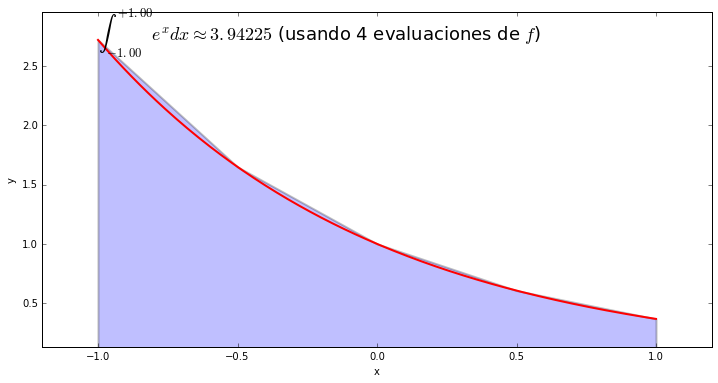

Approximated sum: 3.9422469174292463


In [5]:
def trapezoid(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    h = x[1]-x[0]
    xmiddle = x[1:-1]
    int_val = 0.5*h*sum(f(x[0])+2*f(xmiddle)+f(x[-1]))
    if verbose:
        xbin = x
        ybin = f(x) 
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

N = 4
#myfun = lambda x : x**2
print('Approximated sum: {0}'.format(trapezoid(myfun, N, a, b, verbose=True, text=text, figname="trapezoid_%d.png"%N)))

<div id='rs' />
## Regla de Simpson ##

La extensión lógica a la regla anterior, es utilizar polinomio de grado $2$ (parábolas) para aproximar la función $f$. Para ello, cada tres puntos $(x_k,f(x_k))$, $(x_{k+1},f(x_{k+1}))$ y $(x_{k+2},f(x_{k+2}))$ una parábola es utilizada para aproximar la función. 


Al particionar el intervalo $[a,b]$ en $m$ segmentos y $m+1$ puntos $a = x_0 < \cdots < x_{m} = b \ \ $, con $\ m\ $ par, se obtiene el siguiente resultado:

\begin{align*}
\int_{a}^{b} f(x) dx = \frac{h}{3}(f(x_0) + \sum_{i=1}^{N-1} 6 f(x_i) +  f(x_N)) - \underbrace{(b-a)\frac{h^4}{90} f^{(4)}(c)}_{\text{Error term}}
\end{align*}
donde $h=(x_{i+1}-x_i) \ \ $ y $c \in [a, b]$

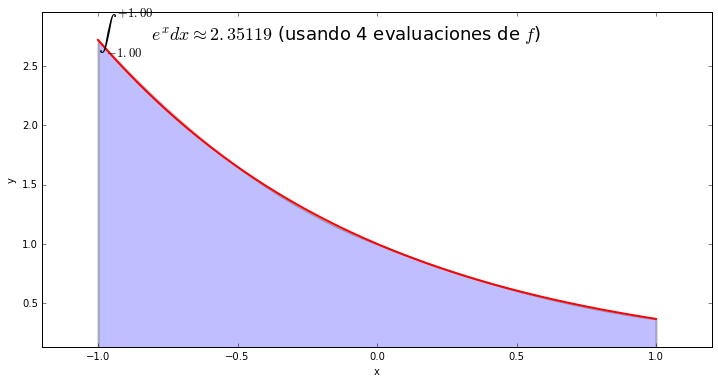

Approximated sum: 2.3511948318802554


In [6]:
def simpsons(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points
    if N%2==1:
        if verbose: print("Simpsons rule only applicable to even number of segments")
        return np.nan
    dx = x[1]-x[0]
    xleft   = x[:-2:2]
    xmiddle = x[1::2]
    xright  = x[2::2]
    int_val = sum((f(xleft)+4*f(xmiddle)+f(xright))*dx/3)
    if verbose:
        xbin, ybin = simpsons_bins(f, xleft, xmiddle, xright)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

def simpsons_bins(f, xleft, xmiddle, xright):
    xbin, ybin = [], []
    n = 21
    for x0, x1, x2 in zip(xleft, xmiddle, xright):
        x = np.linspace(x0, x2, n)
        y = (f(x0)*(x-x1)*(x-x2)) / ((x0-x1)*(x0-x2))
        y+= (f(x1)*(x-x0)*(x-x2)) / ((x1-x0)*(x1-x2))
        y+= (f(x2)*(x-x0)*(x-x1)) / ((x2-x0)*(x2-x1))
        xbin.extend(list(x))
        ybin.extend(list(y))
    return np.array(xbin), np.array(ybin)

print('Approximated sum: {0}'.format(simpsons(myfun, N, a, b, verbose=True, text=text, figname="simpsons_%d.png"%N)))

<div id='mp' />
## Midpoint ##

Una de las limitaciones de las dos reglas anteriores, es que requieren evaluar $f$ en los extremos del intervalo, y pueden haber casos en donde $f$ no esté bien definida en tales puntos.

La regla del punto medio _midpoint_ para cada dos puntos $(x_k,f(x_k))$ y $(x_{k+1},f(x_{k+1}))$, aproxima la función por una expansión de Taylor de grado $1$, centrada en el punto medio $\displaystyle \left( \frac{x_k+x_{k+1}}{2}, f\left(\frac{x_k+x_{k+1}}{2} \right) \right)$, es decir, aproxima $f$ por un polinomio de grado $1$ (al igual que la regla del trapecio).

Al particionar el intervalo $[a,b]$ en $m$ segmentos y $m+1$ puntos $a = x_0 < \cdots < x_{m} = b \ \ $, se obtiene el siguiente resultado:

\begin{align*}
\int_{a}^{b} f(x) dx = \sum_{i=1}^{m} \int_{x_{i-1}}^{x_{i}} f(x) dx  \\
                     = \sum_{i=1}^{m} h f(w_i) + \underbrace{\frac{(b-a)}{24} h^2 f''(c)}_{\text{Error term}}
\end{align*}
donde $h=(b-a)/m \ \ \ $,
$w_i=\frac{1}{2}(x_{i-1}+x_{i})\ \ \ $
y
$\ \ c \in [a, b]$

/Users/claudio/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:9: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/claudio/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


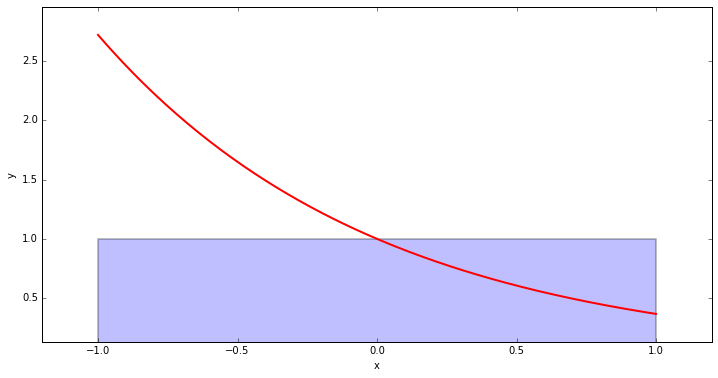

Approximated sum: 2.0


In [7]:
def midpoint(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    dx = x[1]-x[0]
    midpoints = x[:-1] + .5*dx
    midpoint_values = f(midpoints)
    int_val = sum(midpoint_values*dx)
    if verbose:
        xbin = np.vstack([x[:-1], x[1:]]).flatten(1)
        ybin = np.vstack([midpoint_values, midpoint_values]).flatten(1)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

N = 1
#myfun = lambda x : x + 1
print('Approximated sum: {0}'.format(midpoint(myfun, N, a, b, verbose=True, text=text, figname="midpoint_%d.png"%N)))

<div id='cg' />
# Cuadratura Gaussiana #

Similar a las ideas que propuso Chebyshev para mejorar los método de interpolación, nace la siguiente pregunta:

* _¿Se podrá mejorar el proceso de integración particionando $[a,b]$ de una forma no equiespaciada?_

La respuesta a esta pregunta es __sí__. De modo análogo a los puntos de Chebyshev, aca podemos seleccionar las raíces de los polinomios de Legendre $p_n(x)$ siguientes:
\begin{align*}
p_n(x) = \frac{1}{2^n n!} \frac{d^n}{dx^n} \left[ (x^2 - 1)^n \right]
\end{align*}
para luego interpolar $f$ sobre estos puntos, generando un polinomio $p_{n-1}$ sobre el cual realizar la integración.

Este método utiliza la siguiente aproximación, para un intervalo $[-1,1]$:
\begin{align*}
\int_{a}^{b} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)
\end{align*}
donde los $x_i$ se definen como las raíces del n-ésimo polinomio de Legendre $p_n(x)$, y los $w_i$ se calculan como:
$$
w_i = \int_{-1}^{1}L_{i}(x)dx, \ \ \  i = 1,\dots,n
$$
siendo $L_i(x)$ los conocidos polinomio de la interpolación de Lagrange.


__Nota__: Para un intervalo arbitrario $[a,b]$ es necesario realizar la transformación lineal correspondiente.

/Users/claudio/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/claudio/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:25: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


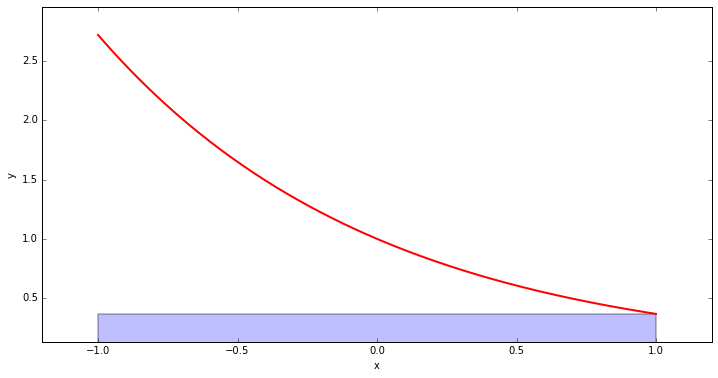

Approximated sum: 0.7357588823428847


In [8]:
def gaussianquad(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x, w = gaussian_nodes_and_weights(N, a, b)
    int_val = sum( w * f(x) )
    if verbose:
        xbin, ybin = gaussian_bins(f, x, w)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

def gaussian_nodes_and_weights(N, a, b):
    if N==1: return np.array([1]), np.array([2])
    beta = .5 / np.sqrt(1.-(2.*np.arange(1.,N))**(-2))
    T = np.diag(beta,1) + np.diag(beta,-1)
    D, V = np.linalg.eigh(T)
    x = D
    x = .5 * ( (b-a)*x + b + a) # Rescaling
    w = 2*V[0,:]**2
    w = .5*(b-a)*w
    return x, w

def gaussian_bins(f, x, w):
    z = [a] + list(a + w.cumsum())
    xbin = np.vstack([z[:-1], z[1:]]).flatten(1)
    z = f(x)
    ybin = np.vstack([z[:], z[:]]).flatten(1)
    return np.array(xbin), np.array(ybin)

print('Approximated sum: {0}'.format(gaussianquad(myfun, N, a, b, verbose=True, 
                                    text=text, figname="gaussianquad_%d.png"%N)))

## Preguntas
* El método de _Midpoint_ y el del Trapecio se basan ambos en aproximaciones por polinomio de grado $1$. ¿Cuál considera usted mejor?. _Hint:_ Considere la cantidad de evaluaciones de funciones, y el termino de error.
* ¿Cuál es la importancia del término $h$ en los _Error term_ de cada método?
* ¿Cuál es la importancia del orden de la derivada $f^{(k)}(c)$ en los _Error term_ de cada método?


<div id='ac' />
# Análisis de Convergencia

Para entender bien el concepto de convergencia, es fundamental entender correctamente dos conceptos:

* **Grado de Precisión (Degree of Precision)**. Para un método de integración numérica, corresponde al mayor entero $k$ para el cual todos los polinomios de grado $k$ o menor, son integrados exactamente (sin error). Si recordamos los métodos ya estudiados, el término de error tiene la forma general:
$$
\text{Error term} = C \ h^p \ f^{(q)}(c) \ \ \ \ \text{con} \ \ C \ \text{constante} \ \ \text{y} \ \ p,q \in \mathbb{N}
$$
Dado que para cualquier polinomio de grado $\leq q-1$ se obtiene que $f^{(q)}=0$, entonces el _grado de precisión_ de un tal método, viene determinado por el orden de la derivada, y es $q-1$.
* **Orden de convergencia.** El orden de convergencia está derminada por la otra componente del _Error term_, esto es, por $h^p$. Recordar que $h$ debe ser _pequeño_ ($h < 1$), y por lo tanto a mayor potencia $p$, menor será el orden del método. El orden de convergencia, nos dice _cómo decrece el error a medida que se aumentan la cantidad de puntos de la malla_. 


A continuación compararemos gráficamente la convergencia de estos métodos:

In [9]:
def get_error(quadrature_rule, myfun, Nrange, a, b, true_value):
    quad_error = []
    for N in Nrange:
        error = np.abs(true_value - quadrature_rule(myfun, N, a, b) )
        if error<1E-16:
            quad_error.append(1E-16)
        else:
            quad_error.append(error)
    return quad_error

def set_ylim(ymin, ymax):
    ymin = min(plt.ylim()[0], ymin)
    ymax = max(plt.ylim()[1], ymax)
    plt.ylim([ymin, ymax])
    return

def convergence(Nrange, myfun, a, b, true_value):
    ms = 10
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    e_mp = get_error(midpoint, myfun, Nrange, a, b, true_value)
    e_tr = get_error(trapezoid, myfun, Nrange, a, b, true_value)
    e_sp = get_error(simpsons, myfun, Nrange, a, b, true_value)
    e_gq = get_error(gaussianquad, myfun, Nrange, a, b, true_value)
    plt.figure(figsize=(12,16))
    # First plot
    ax = plt.subplot(4,1,1)
    dd = 0.1*(b-a)
    x = np.linspace(a-dd, b+dd, 1000)
    plt.plot(x, f(x), 'k', label="f(x)", lw=2.0)
    x = np.linspace(a, b, 1000)
    plt.fill_between(x, f(x), 0, alpha=0.5, label=r"$\int_a^b f(x) dx$")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    ymax = 1.05*plt.ylim()[1]
    plt.ylim([-ymax, ymax])
    plt.grid('on')
    plt.legend(loc="lower left")
    # Second plot
    ax = plt.subplot(4,1,2) 
    plt.plot(Nrange, e_mp, 'sb', lw=2.0, ms=ms, label="Midpoint")
    plt.plot(Nrange, e_tr, 'or', lw=2.0, ms=ms, label="Trapezoid")
    plt.plot(Nrange, e_gq, 'Dw', lw=2.0, ms=ms, label="Gaussian Quad")
    plt.plot(Nrange, e_sp, '>y', lw=2.0, ms=ms, label="Simpsons")
    set_ylim(-5E-2, 1E-1)
    plt.xlabel("N")
    plt.ylabel("Error")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=4, fancybox=True, shadow=True, numpoints=1)
    plt.grid('on')
    # Third plot
    plt.subplot(4,1,3)
    plt.loglog(Nrange, e_mp, 'sb', ms=ms, lw=2.0)
    plt.loglog(Nrange, e_tr, 'or', ms=ms, lw=2.0)
    plt.loglog(Nrange, e_sp, '>y', ms=ms, lw=2.0)
    plt.loglog(Nrange, e_gq, 'Dw', ms=ms, lw=2.0)
    set_ylim(1E-18, 1E+1)
    N = np.arange(1,101,10)
    plt.loglog(N, 1./N, '-k', lw=2.0, alpha=0.5)
    plt.loglog(N, 1./N**2, '-k', lw=2.0, alpha=0.5)
    plt.loglog(N, 1./N**3, '-k', lw=2.0, alpha=0.5)
    plt.loglog(N, 1./N**4, '-k', lw=2.0, alpha=0.5)
    plt.xlabel("N")
    plt.ylabel("Error")
    plt.grid('on')
    # Forth plot
    plt.subplot(4,1,4)
    h = 1./np.arange(1,101,10)
    plt.loglog(h, h, '-k', lw=2.0, alpha=0.5)
    plt.loglog(h, h**2, '-k', lw=2.0, alpha=0.5)
    plt.loglog(h, h**3, '-k', lw=2.0, alpha=0.5)
    plt.loglog(h, h**4, '-k', lw=2.0, alpha=0.5)
    # Plotting Gaussian Quadratupre first but using larger markers
    h = 1./np.array(Nrange)
    plt.loglog(h, e_gq, 'Dw', lw=2.0, ms=ms)
    plt.loglog(h, e_mp, 'sb', lw=2.0, ms=ms)
    plt.loglog(h, e_tr, 'or', lw=2.0, ms=ms)
    plt.loglog(h, e_sp, '>y', lw=2.0, ms=ms)
    set_ylim(1E-18, 1E+1)
    plt.xlabel("h")
    plt.ylabel("Error")
    plt.grid('on')
    plt.show()

### Parámetros

A continuación, se defininen los parámetros a utilizar en nuestros experimentos.

In [10]:
###########################
# Function 1: Constant
# All methods are good
Ns = range(4, 11)
x0, x1, x2 = 5., -1., 3.
f = lambda x : x2*x**2 + x1*x + x0
a = -1.0
b = +1.0
sol = (x2/3.)*(b**3-a**3)  + x0*(b-a)
exp1 = (Ns, f, a, b, sol)

###########################
# Function 2: sin
# All method equal if symmetric interval
# Gaussian quad better if asymmetric interval
Ns = range(4, 100)
f = lambda x : np.sin(x)
a = 0.0
b = +1.0
sol = -np.cos(b)+np.cos(a)
exp2 = (Ns, f, a, b, sol)

###########################
# Function 3: gaussian bell
# gaussian quad outperforms all the other methods
Ns = range(4, 20)
f = lambda x : np.exp(-x**2)
a = -1.0
b = +1.0
sol = 1.4936482656248541 # Specific value for the range [-1,1]
exp3 = (Ns, f, a, b, sol)


###########################
# Function 4: exponential
# gaussian quad outperforms all the other methods
Ns = range(4, 20)
f = lambda x : np.exp(x)
a = -1.0
b = +2.0
sol = np.exp(b) - np.exp(a)
exp4 = (Ns, f, a, b, sol)

###########################
# Function 5: logarithm
Ns = range(4, 20)
f = lambda x : np.log(np.abs(x))
a = 1E-6
b = +1.0
sol = (b*np.log(b)-b) - (a*np.log(a)-a)#-2.0000000000000000
exp5 = (Ns, f, a, b, sol)

###########################
# Function 6 and true value
Ns = range(4, 20)
f = lambda x : np.sin(x)/x #if abs(x)>1e-6 else 1.0
a = -1.0
b = +1.0
sol = 1.8921661407343660
exp6 = (Ns, f, a, b, sol)

###########################
# Function 7 : absolute value
# Midpoint wins
# Do (-1,1) and (-2,1)
Ns = range(4, 20)
f = lambda x : abs(x)
a = -1 #-np.pi
b = +1.0
sol = (a**2+b**2)/2.
exp7 = (Ns, f, a, b, sol)

###########################
# Function 8 : Gaussian
# Midpoint/Traps wins over gaussian
Ns = range(4, 100)
f = lambda x : np.exp(-x**2)
a = -10.0
b = +10.0
sol = np.sqrt(math.pi)
exp8 = (Ns, f, a, b, sol)

###########################
# Function 9 : 1/x^2
# Gaussian wins, but they all degrade if a->0
# Here we should try an adaptative method
Ns = range(4, 20)
f = lambda x : 1.0/(x**2)
a = 1E-4
b = +1.
sol = 1.0/a - 1.0/b
exp9 = (Ns, f, a, b, sol)

### Test de Convergencia
Finalmente podemos testear la convergencia de nuestros métodos

/Users/claudio/anaconda/lib/python3.4/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


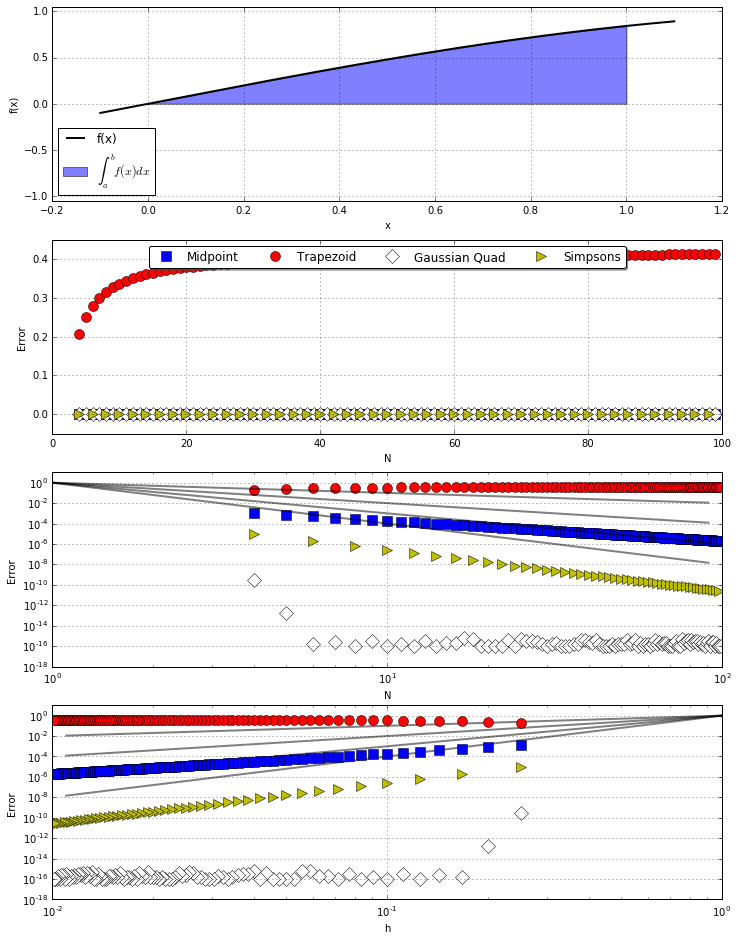

In [11]:
convergence(*exp2)

<div id='at' />
# Análisis de Tiempo

Usamos el siguiente decorador para medir los tiempos de ejecución de las funciones

In [12]:
def timeit(f):
    def timed(*args, **kw):
        N = 10
        T = 0.
        for i in range(N):
            ts = time.time()
            result = f(*args, **kw)
            te = time.time()
            T += (te-ts)*1000. # In ms  
        return T/N
    return timed

In [13]:
"""
Decorated functions
"""
@timeit
def t_trapezoid(myfun, N, a, b):
    return trapezoid(myfunc, N, a, b)

@timeit
def t_simpsons(myfun, N, a, b):
    return simpsons(myfunc, N, a, b)

@timeit
def t_midpoint(myfun, N, a, b):
    return midpoint(myfun, N, a, b)

@timeit
def t_gaussianquad(myfun, N, a, b):
    return gaussianquad(myfunc, N, a, b)

In [14]:
def timing(Nrange, myfun, a, b, true_value):
    ms = 10
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    e_mp = get_error(midpoint, myfun, Nrange, a, b, true_value)
    e_tr = get_error(trapezoid, myfun, Nrange, a, b, true_value)
    e_sp = get_error(simpsons, myfun, Nrange, a, b, true_value)
    e_gq = get_error(gaussianquad, myfun, Nrange, a, b, true_value)
    plt.figure(figsize=(12,16))
    # First plot
    ax = plt.subplot(4,1,1)
    dd = 0.1*(b-a)
    x = np.linspace(a-dd, b+dd, 1000)
    plt.plot(x, f(x), 'k', label="f(x)", lw=2.0)
    x = np.linspace(a, b, 1000)
    plt.fill_between(x, myfun(x), 0, alpha=0.5, label=r"$\int_a^b f(x) dx$")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    ymax = 1.05*plt.ylim()[1]
    plt.ylim([-ymax, ymax])
    plt.grid('on')
    plt.legend(loc="lower left")
    # Second plot
    ax = plt.subplot(4,1,2) 
    plt.plot(Nrange, e_mp, 'sb', lw=2.0, ms=ms, label="Midpoint")
    plt.plot(Nrange, e_tr, 'or', lw=2.0, ms=ms, label="Trapezoid")
    plt.plot(Nrange, e_gq, 'Dw', lw=2.0, ms=ms, label="Gaussian Quad")
    plt.plot(Nrange, e_sp, '>y', lw=2.0, ms=ms, label="Simpsons")
    set_ylim(-5E-2, 1E-1)
    plt.xlabel("N")
    plt.ylabel("Tiempo [ms]")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=4, fancybox=True, shadow=True, numpoints=1)
    plt.grid('on')
    # Third plot
    plt.subplot(4,1,3)
    plt.loglog(Nrange, e_mp, 'sb', ms=ms, lw=2.0)
    plt.loglog(Nrange, e_tr, 'or', ms=ms, lw=2.0)
    plt.loglog(Nrange, e_sp, '>y', ms=ms, lw=2.0)
    plt.loglog(Nrange, e_gq, 'Dw', ms=ms, lw=2.0)
    #set_ylim(1E-18, 1E+1)
    plt.xlabel("N")
    plt.ylabel("Tiempo [ms]")
    plt.grid('on')
    # Forth plot
    plt.subplot(4,1,4)
    # Plotting Gaussian Quadratupre first but using larger markers
    h = 1./np.array(Nrange)
    plt.loglog(h, e_gq, 'Dw', lw=2.0, ms=ms)
    plt.loglog(h, e_mp, 'sb', lw=2.0, ms=ms)
    plt.loglog(h, e_tr, 'or', lw=2.0, ms=ms)
    plt.loglog(h, e_sp, '>y', lw=2.0, ms=ms)
    #set_ylim(1E-18, 1E+1)
    plt.xlabel("h")
    plt.ylabel("Tiempo [ms]")
    plt.grid('on')
    plt.show()

### Parámetros 
A continuación, se definen variables y parámetros a utilizar en el experimento.

In [15]:
sol = 0.0 # Reference value

###########################
# Function 1: Constant
# All methods are good
Ns = range(4, 205, 20)
f = lambda x : 1.0
a = -1.0
b = +1.0
exp1 = (Ns, f, a, b, sol)

###########################
# Function 2: sin
# All method equal if symmetric interval
# Gaussian quad better if asymmetric interval
Ns = range(4, 20)
f = lambda x : np.sin(x)
a = -2.0
b = +1.0
exp2 = (Ns, f, a, b, sol)

###########################
# Function 3: gaussian bell
# gaussian quad outperforms all the other methods
Ns = range(4, 205, 20)
f = lambda x : np.exp(-x**2)
a = -1.0
b = +1.0
exp3 = (Ns, f, a, b, sol)


###########################
# Function 4: exponential
# gaussian quad outperforms all the other methods
Ns = range(4, 20)
f = lambda x : np.exp(x)
a = -1.0
b = +2.0
exp4 = (Ns, f, a, b, sol)

###########################
# Function 5: logarithm
Ns = range(4, 20)
f = lambda x : np.log(np.abs(x))
a = 1E-6
b = +1.0
exp5 = (Ns, f, a, b, sol)

###########################
# Function 6 and true value
Ns = range(4, 20)
f = lambda x : np.sin(x)/x
a = -1.0
b = +1.0
exp6 = (Ns, f, a, b, sol)

###########################
# Function 7 : absolute value
# Midpoint wins
# CHECK ME
# Do (-1,1) and (-2,1)
Ns = range(4, 20)
f = lambda x : abs(x)
a = -1.0
b = +1.0
exp7 = (Ns, f, a, b, sol)

###########################
# Function 8 : Gaussian
# Midpoint/Traps wins over gaussian
Ns = range(4, 100)
f = lambda x : np.exp(-x**2)
a = -10.0
b = +10.0
exp8 = (Ns, f, a, b, sol)

###########################
# Function 9 : 1/x^2
# Gaussian wins, but they all degrade if a->0
# Here we should try an adaptative method
Ns = range(4, 20)
f = lambda x : 1.0/(x**2)
a = 1E-2
b = +1.
exp9 = (Ns, f, a, b, sol)

### Test de tiempos

Finalmente podemos testear los tiempos de nuestros métodos

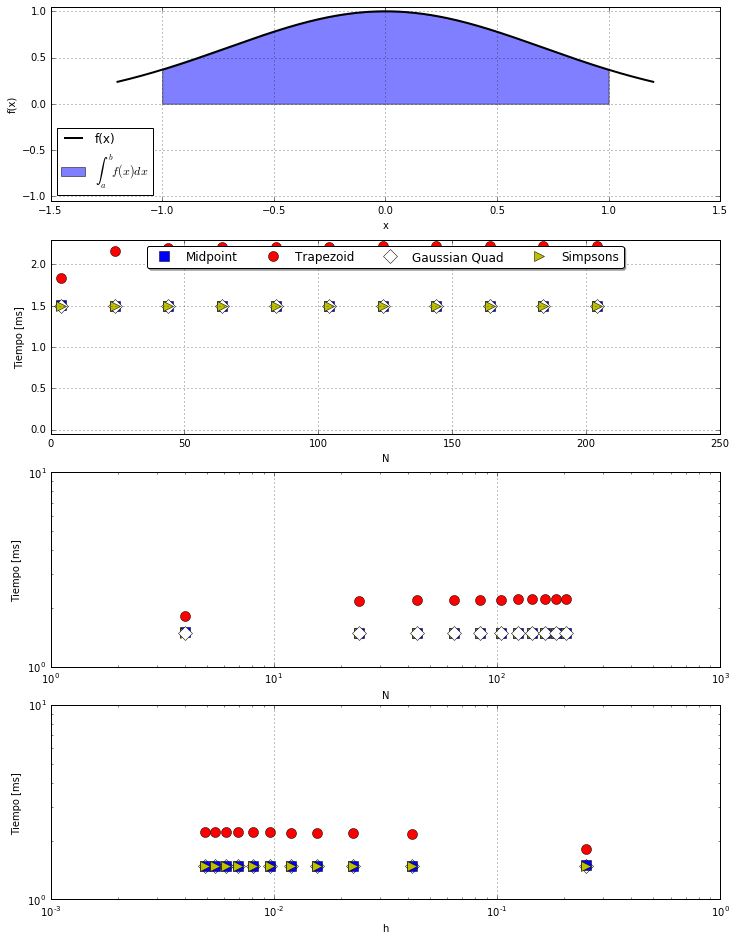

In [16]:
timing(*exp3)

<div id='acknowledgements' />
# Acknowledgements
* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín Villanueva. DI UTFSM. Abril 2016._

***
### DISCLAIMER ###

El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). 

El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y Sebastian Flores <sebastian.flores@usm.cl>, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.

[Update 2016] (Martín) Notebook creado como una fusión de las tres partes anteriores. Modificadas funciones de integración con parámetro verbose para controlar la salida, y añadido el decorador para medir los tiempos. 
***